In [26]:
import pybullet as p
import random
import numpy as np
from sim_class import Simulation
import imageio
import sim_class
import time
import matplotlib.pyplot as plt

# PID

In [27]:
class PID:
    def __init__(self, kp, ki, kd, setpoint=0.0):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self._integral = 0.0
        self._prev_measurement = None

    def reset(self):
        self._integral = 0.0
        self._prev_measurement = None

    def update(self, measurement, dt):
        """
        measurement: current system value
        dt: timestep in seconds
        returns: control output u
        """
        if dt <= 0:
            raise ValueError("dt must be > 0")

        # Error
        error = self.setpoint - measurement

        # Integral term
        self._integral += error * dt

        # Derivative term (derivative on measurement)
        if self._prev_measurement is None:
            d_meas = 0.0
        else:
            d_meas = (measurement - self._prev_measurement) / dt
        self._prev_measurement = measurement

        # PID output (note the minus sign for derivative-on-measurement)
        output = (self.kp * error) + (self.ki * self._integral) - (self.kd * d_meas)

        return output


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def run_pid_3axis(setpoint, kp, ki, kd, dt=0.025, max_steps=1000, tol=0.001, out_limit=5.0):
    # three separate controllers (one per axis)
    env = Simulation(num_agents=1)
    pid_x = PID(kp, ki, kd, setpoint=float(setpoint[0]))
    pid_y = PID(kp, ki, kd, setpoint=float(setpoint[1]))
    pid_z = PID(kp, ki, kd, setpoint=float(setpoint[2]))

    t_hist = []
    pos_hist = []
    u_hist = []
    err_hist = []
    err_norm_hist = []

    for step in range(max_steps):
        t = step * dt

        # 1) measure
        pip = np.array(env.get_pipette_position(robotId=env.robotIds[0]), dtype=float)

        # 2) update the three independent PIDs (real-life approach)
        ux = pid_x.update(pip[0], dt)
        uy = pid_y.update(pip[1], dt)
        uz = pid_z.update(pip[2], dt)

        # 3) clamp outputs (your PID class has no output_limits)
        ux = float(np.clip(ux, -out_limit, out_limit))
        uy = float(np.clip(uy, -out_limit, out_limit))
        uz = float(np.clip(uz, -out_limit, out_limit))

        # 4) apply once per tick
        env.apply_actions([[ux, uy, uz, 0]])
        p.stepSimulation()

        # 5) log
        err = setpoint - pip
        err_norm = float(np.linalg.norm(err))

        t_hist.append(t)
        pos_hist.append(pip.copy())
        u_hist.append([ux, uy, uz])
        err_hist.append(err.copy())
        err_norm_hist.append(err_norm)
        if err_norm < tol:
            print(
                f"Tolerance reached at step {step} "
                f"(time = {t:.3f} s, error norm = {err_norm:.6f})"
            )

    env.close()

    return {
        "t": np.array(t_hist),
        "pos": np.array(pos_hist),        # Nx3
        "u": np.array(u_hist),            # Nx3
        "err": np.array(err_hist),        # Nx3
        "err_norm": np.array(err_norm_hist),
        "step": np.array(step),
    }

def plot_pid_summary(data, setpoint):
    t = data["t"]
    pos = data["pos"]
    err_norm = data["err_norm"]
    step = data["step"]

    # Position plot (shows overshoot)
    plt.figure()
    plt.plot(t, pos[:, 0], label="x")
    plt.plot(t, pos[:, 1], label="y")
    plt.plot(t, pos[:, 2], label="z")
    plt.axhline(setpoint[0], linestyle="--", label="x setpoint")
    plt.axhline(setpoint[1], linestyle="--", label="y setpoint")
    plt.axhline(setpoint[2], linestyle="--", label="z setpoint")
    plt.xlabel("Time [s]")
    plt.ylabel("Position")
    plt.grid(True)
    plt.legend()

    # Error norm plot
    plt.figure()
    plt.plot(t, err_norm, label="||error||")
    plt.xlabel("Time [s]")
    plt.ylabel("Error norm")
    plt.grid(True)
    plt.legend()

    plt.show()


In [29]:
# target
setpoint = np.array([0.2031, 0.2095, 0.2196], dtype=float) # coordinates x, y, z

# First Iteration

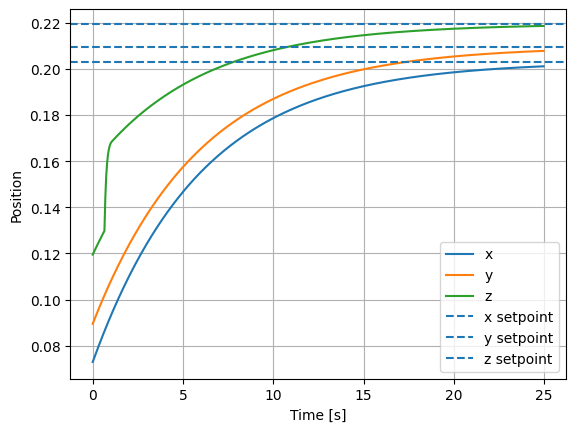

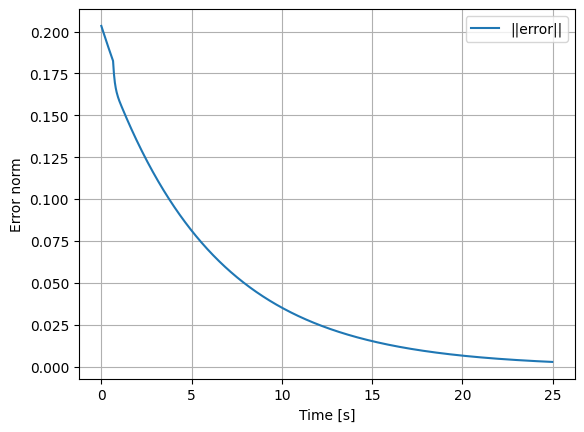

In [30]:
data = run_pid_3axis(setpoint, kp=1.0, ki=0.0, kd=0.0, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observations: the position is going smoothly to the target position on each axis. Also error is smoothly deacrissing.  `z` has visible 'jump' deafult start position is below the `z` axis range. Surprisingly there is NOT visible overshooting. I expected that overshoot of the target, some divergence. More over with those parameters axis didn't reach error less than 0.001

- Tested Kp = 1.0, Ki=0.0, Kd=0
- Error < 0.001 not achieved in 1000 steps
  
Next values Kp = 2.0, Ki=0.0, Kd=0

# Second Iteration

Tolerance reached at step 624 (time = 15.600 s, error norm = 0.000994)
Tolerance reached at step 625 (time = 15.625 s, error norm = 0.000986)
Tolerance reached at step 626 (time = 15.650 s, error norm = 0.000977)
Tolerance reached at step 627 (time = 15.675 s, error norm = 0.000969)
Tolerance reached at step 628 (time = 15.700 s, error norm = 0.000961)
Tolerance reached at step 629 (time = 15.725 s, error norm = 0.000953)
Tolerance reached at step 630 (time = 15.750 s, error norm = 0.000944)
Tolerance reached at step 631 (time = 15.775 s, error norm = 0.000936)
Tolerance reached at step 632 (time = 15.800 s, error norm = 0.000928)
Tolerance reached at step 633 (time = 15.825 s, error norm = 0.000920)
Tolerance reached at step 634 (time = 15.850 s, error norm = 0.000912)
Tolerance reached at step 635 (time = 15.875 s, error norm = 0.000905)
Tolerance reached at step 636 (time = 15.900 s, error norm = 0.000897)
Tolerance reached at step 637 (time = 15.925 s, error norm = 0.000889)
Tolera

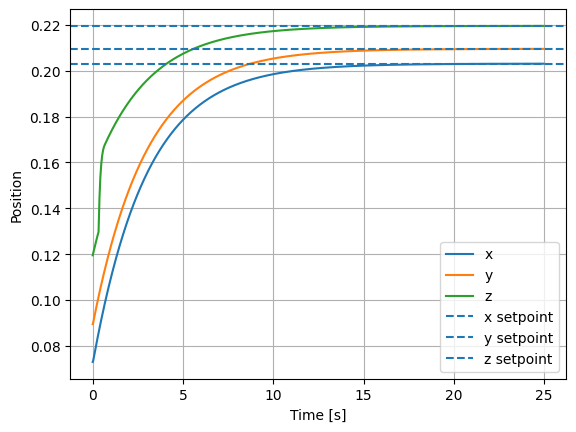

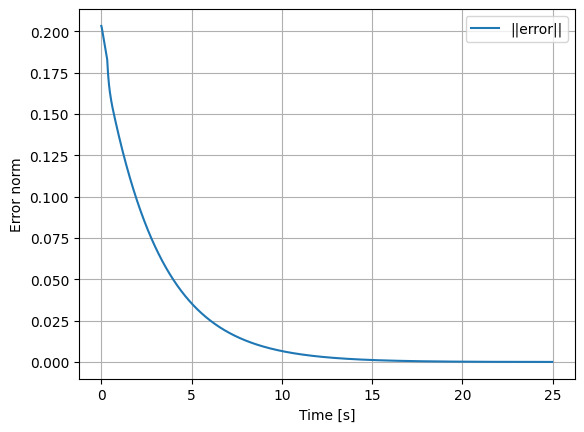

In [31]:
data = run_pid_3axis(setpoint, kp=2.0, ki=0.0, kd=0.0, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observations: The same observation like in first iteration but with one difference, the error is decaying faster what means the position of the robot is going faster to the right possition. No sings of overshooting what seems to be strange.

- Tested Kp=2.0, Ki=0.0, Kd=0
- Error < 0.001 reached ond 624 step

Next values Kp=10.0, Ki=0.0, Kd=0



# Third Iteration

Tolerance reached at step 128 (time = 3.200 s, error norm = 0.000996)
Tolerance reached at step 129 (time = 3.225 s, error norm = 0.000954)
Tolerance reached at step 130 (time = 3.250 s, error norm = 0.000914)
Tolerance reached at step 131 (time = 3.275 s, error norm = 0.000875)
Tolerance reached at step 132 (time = 3.300 s, error norm = 0.000838)
Tolerance reached at step 133 (time = 3.325 s, error norm = 0.000803)
Tolerance reached at step 134 (time = 3.350 s, error norm = 0.000769)
Tolerance reached at step 135 (time = 3.375 s, error norm = 0.000736)
Tolerance reached at step 136 (time = 3.400 s, error norm = 0.000705)
Tolerance reached at step 137 (time = 3.425 s, error norm = 0.000676)
Tolerance reached at step 138 (time = 3.450 s, error norm = 0.000647)
Tolerance reached at step 139 (time = 3.475 s, error norm = 0.000620)
Tolerance reached at step 140 (time = 3.500 s, error norm = 0.000593)
Tolerance reached at step 141 (time = 3.525 s, error norm = 0.000568)
Tolerance reached at

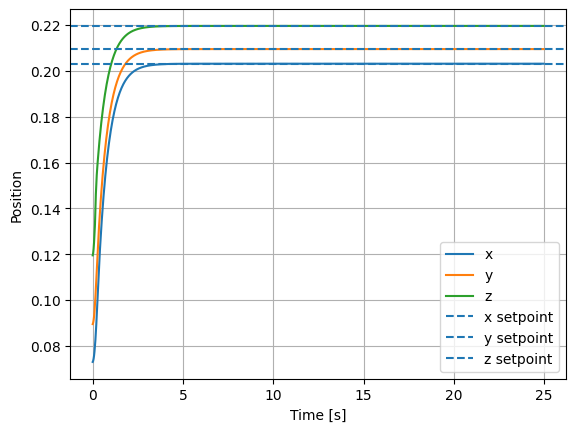

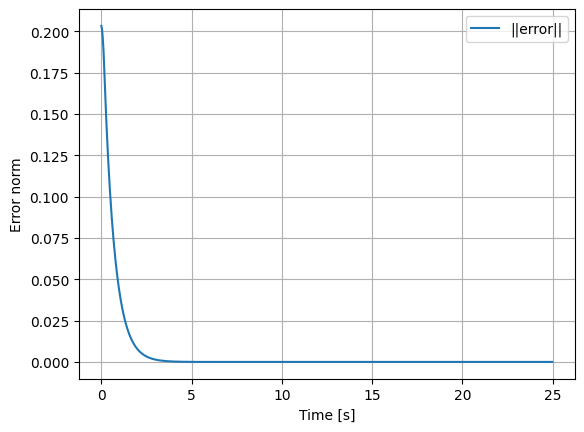

In [32]:
data = run_pid_3axis(setpoint, kp=10.0, ki=0.0, kd=0.0, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observations: Both shows that each axis is going even faster to the target. No overshoot occured.


- Tested Kp=10.0, Ki=0.0, Kd=0
- Error < 0.001 reached ond 128 step

Next values Kp=25.0, Ki=0.0, Kd=0

# Fourth Iteration

Tolerance reached at step 56 (time = 1.400 s, error norm = 0.000895)
Tolerance reached at step 57 (time = 1.425 s, error norm = 0.000802)
Tolerance reached at step 58 (time = 1.450 s, error norm = 0.000718)
Tolerance reached at step 59 (time = 1.475 s, error norm = 0.000642)
Tolerance reached at step 60 (time = 1.500 s, error norm = 0.000575)
Tolerance reached at step 61 (time = 1.525 s, error norm = 0.000515)
Tolerance reached at step 62 (time = 1.550 s, error norm = 0.000461)
Tolerance reached at step 63 (time = 1.575 s, error norm = 0.000412)
Tolerance reached at step 64 (time = 1.600 s, error norm = 0.000369)
Tolerance reached at step 65 (time = 1.625 s, error norm = 0.000330)
Tolerance reached at step 66 (time = 1.650 s, error norm = 0.000295)
Tolerance reached at step 67 (time = 1.675 s, error norm = 0.000264)
Tolerance reached at step 68 (time = 1.700 s, error norm = 0.000236)
Tolerance reached at step 69 (time = 1.725 s, error norm = 0.000211)
Tolerance reached at step 70 (time

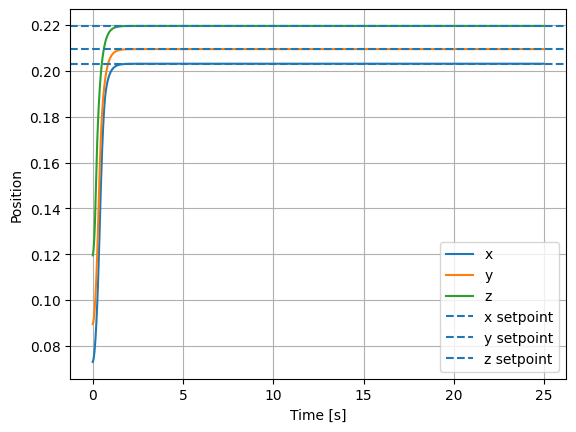

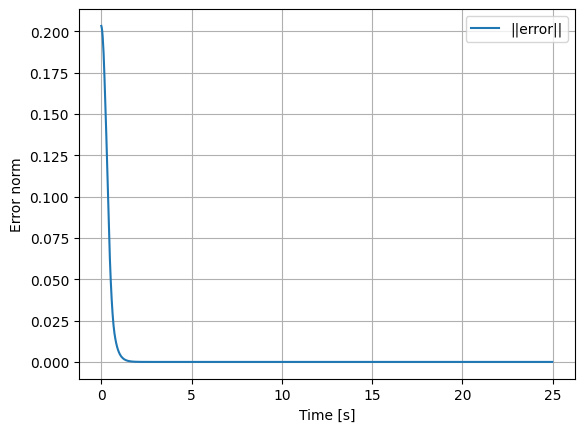

In [33]:
data = run_pid_3axis(setpoint, kp=25.0, ki=0.0, kd=0.0, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observations: significant improvements visible

- Tested Kp=25.0, Ki=0.0, Kd=0
- Error < 0.001 reached ond 56 step

For test purposes, ahigher Kp will be tested to see if any overshoot can occur.

Next values Kp=100.0, Ki=0.0, Kd=0

Tolerance reached at step 66 (time = 1.650 s, error norm = 0.000062)
Tolerance reached at step 78 (time = 1.950 s, error norm = 0.000369)
Tolerance reached at step 79 (time = 1.975 s, error norm = 0.000063)
Tolerance reached at step 80 (time = 2.000 s, error norm = 0.000037)
Tolerance reached at step 81 (time = 2.025 s, error norm = 0.000022)
Tolerance reached at step 82 (time = 2.050 s, error norm = 0.000013)
Tolerance reached at step 83 (time = 2.075 s, error norm = 0.000008)
Tolerance reached at step 84 (time = 2.100 s, error norm = 0.000005)
Tolerance reached at step 85 (time = 2.125 s, error norm = 0.000003)
Tolerance reached at step 86 (time = 2.150 s, error norm = 0.000002)
Tolerance reached at step 87 (time = 2.175 s, error norm = 0.000002)
Tolerance reached at step 88 (time = 2.200 s, error norm = 0.000002)
Tolerance reached at step 89 (time = 2.225 s, error norm = 0.000002)
Tolerance reached at step 90 (time = 2.250 s, error norm = 0.000002)
Tolerance reached at step 91 (time

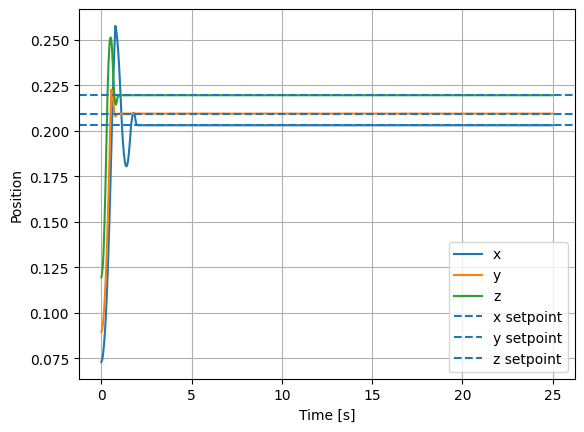

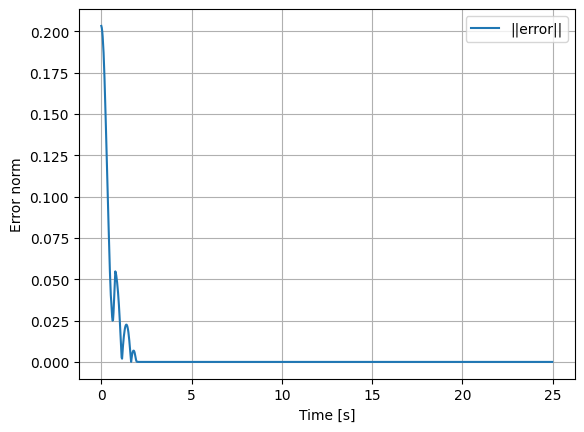

In [34]:
data = run_pid_3axis(setpoint, kp=100.0, ki=0.0, kd=0.0, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observation: The overshoot can occur with higher `Kp` value, however the overshoot is decaying by itself overtime. This result is possible because of specification of the robot which has small work envelope or specific motors and sensors.

The last iteration will be final one.

Tolerance reached at step 49 (time = 1.225 s, error norm = 0.000960)
Tolerance reached at step 50 (time = 1.250 s, error norm = 0.000857)
Tolerance reached at step 51 (time = 1.275 s, error norm = 0.000749)
Tolerance reached at step 52 (time = 1.300 s, error norm = 0.000668)
Tolerance reached at step 53 (time = 1.325 s, error norm = 0.000583)
Tolerance reached at step 54 (time = 1.350 s, error norm = 0.000520)
Tolerance reached at step 55 (time = 1.375 s, error norm = 0.000452)
Tolerance reached at step 56 (time = 1.400 s, error norm = 0.000403)
Tolerance reached at step 57 (time = 1.425 s, error norm = 0.000350)
Tolerance reached at step 58 (time = 1.450 s, error norm = 0.000313)
Tolerance reached at step 59 (time = 1.475 s, error norm = 0.000272)
Tolerance reached at step 60 (time = 1.500 s, error norm = 0.000245)
Tolerance reached at step 61 (time = 1.525 s, error norm = 0.000214)
Tolerance reached at step 62 (time = 1.550 s, error norm = 0.000196)
Tolerance reached at step 63 (time

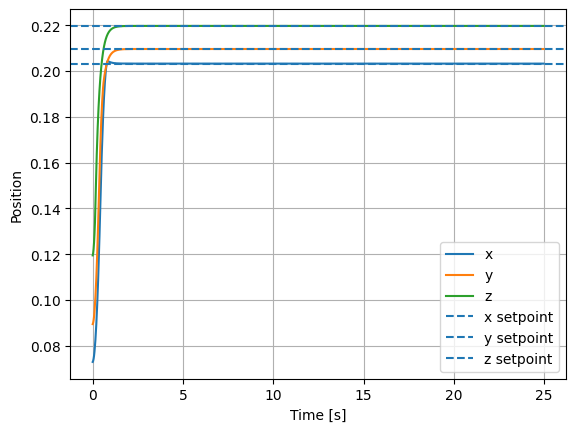

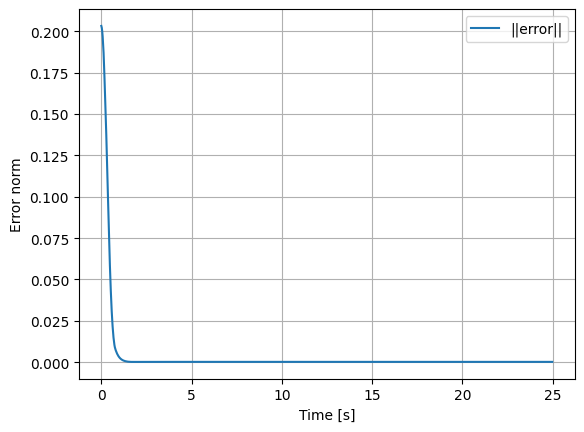

In [39]:
data = run_pid_3axis(setpoint, kp=50.0, ki=0.1, kd=5, dt=0.025, max_steps=1000)

plot_pid_summary(data, setpoint)

Observations: I was able to improve the result rising Kp, Ki, Kd. The iteration speed up the process by 7 steps. This is the last iterattion, further improvemenst are not possible.

Final parameters: `Kp=50.0, Ki=0.1, Kd=5.0`